In [27]:
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
import george
from george import kernels
import numpy as np
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as pl
import flaredetect as fd
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter as sf
from scipy.optimize import minimize
from numpy import asarray
import emcee
import scipy.ndimage.filters as gausFilter
from astropy.stats import LombScargle
from scipy.integrate import simps

class Flare:
    flux = []
    time = []

    def __init__(self, x, y, r1, r2):

        self.flux = y[r1:r2]
        self.flux = self.flux[np.logical_not(np.isnan(self.flux))]
        self.flux = self.flux[np.logical_not(np.isinf(self.flux))]
        self.flux = self.flux.flatten()
        self.time = x[r1:r2]
        self.time = self.time[np.logical_not(np.isnan(self.time))]
        self.flux = self.flux.flatten()
        self.time = self.time[:len(self.flux)]

    def getpeaktimes(self):
        return fd.flaredetecttime(self.time, self.flux)

    def guesspeaks(self):  # gathers the peaks in the set of data, then returns a list of flare times, peaks, and fwhm
        self.detflares = fd.flaredetectpeak(self.flux)
        self.flarecount = fd.getlength()
        self.nflares = np.shape(self.detflares)[0]
        self.params = np.zeros([self.nflares, 3])
        for i, flareVal in enumerate(self.detflares):
            self.flarepeak = flareVal
            self.flaretime = self.findfluxtime(self.flarepeak, self.flux, self.time)
            p = [self.flaretime, 0.004, self.flarepeak]
            self.params[i, :] = p
        return np.log(self.params)

    def findfluxtime(self, flarepeak, flux, time):  # retrieves the time of the flare
        tof = time
        for i, flare in enumerate(flux):
            if flare == flarepeak:
                return tof[i]

    def getmodel(self, p, data):  # computes the model of the flares using appaloosa's aflare1 function
        time, y, nflares = data
        p = np.exp(p)
        model = np.zeros_like([time])
        p = np.reshape(p, (nflares, 3))
        for i in range(nflares):
            model += ap.aflare1(time, tpeak=p[i, 0], fwhm=p[i, 1], ampl=p[i, 2], upsample=False, uptime=10)
        return model


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version


<IPython.core.display.Javascript object>


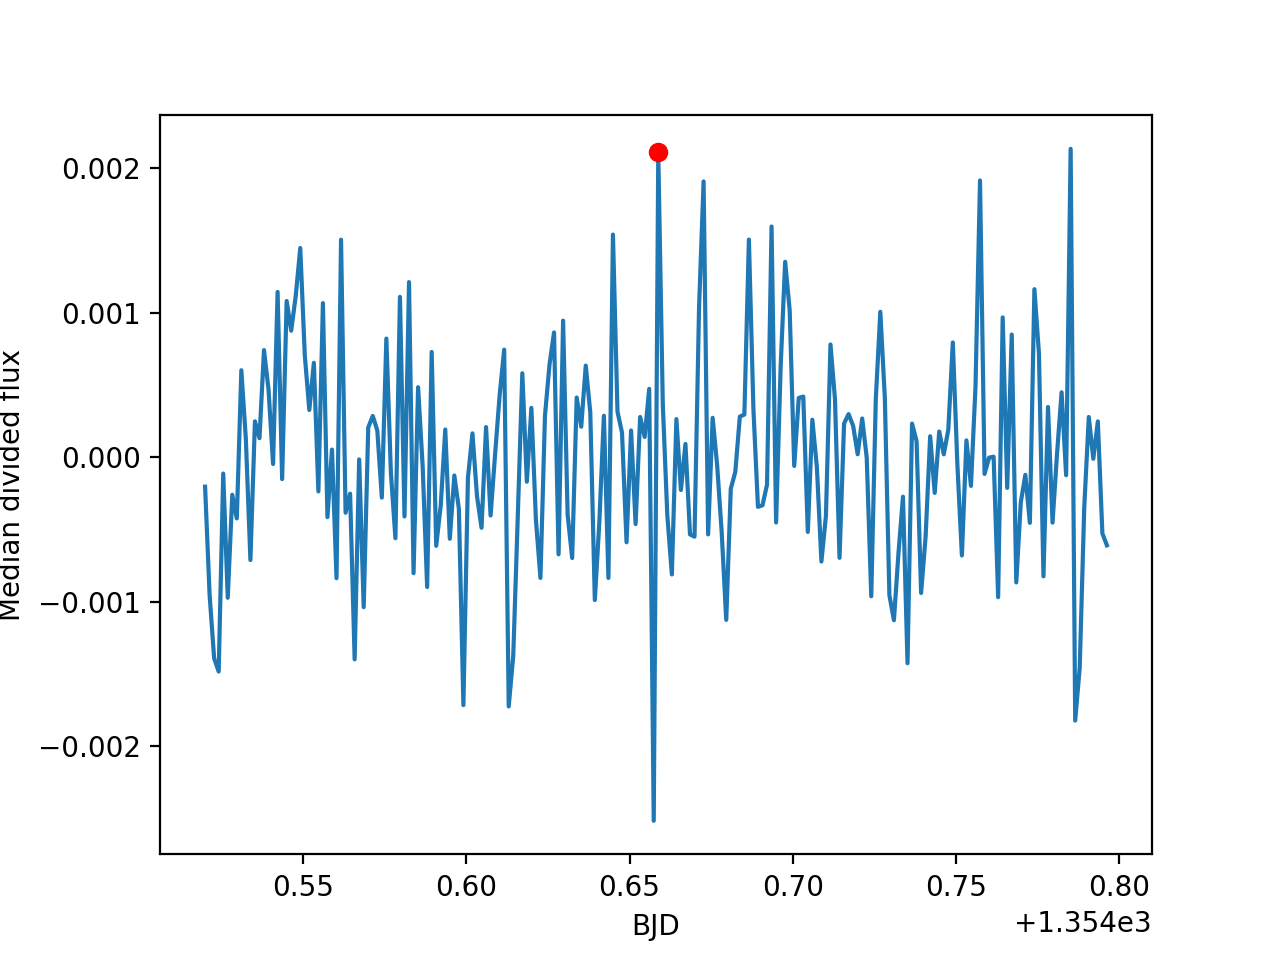

In [40]:
%matplotlib notebook
import matplotlib.pyplot as pl
import numpy as np
import os
global glob_temp
tracker = 2
temp = 1
flux = 0
time = 0

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Simple mouse click function to store coordinates
def onclick(event):
    global timeVar
    global tracker
    global temp
    global time
    global flux
    global coords
    
    timeVar = event.xdata
    coords.append(timeVar)
        
    # Disconnect after 2 clicks
    if len(coords) == tracker:         
        tracker = tracker + 2
        pl.clf()
        pl.xlabel("BJD")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.plot(flare.time[start:end], flare.flux[start:end])
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
        temp = temp+1
        if temp > len(time_peaks):
            fig.canvas.mpl_disconnect(cid)
            pl.clf()
            pl.close()
        

    return


def manualflare(flux, time, time_peaks):
    num_events = len(time_peaks)
    flux = np.asarray(flux)  # convert to np array
    time = np.asarray(time)
    temp_coord = 0
    index = np.where(time == time_peaks[0])[0][0]  # get event index as an int
    start = index - 100 
    end = index + 100                
    fig = pl.figure(1)
    ax = fig.add_subplot(111)
    cur_plot = ax.plot(time[start:end], flux[start:end])  # plot the entire flare event
    ax.plot(time[index], flux[index], marker='o', color='Red')
    pl.xlabel("BJD")
    pl.ylabel("Median divided flux")
    cid = fig.canvas.mpl_connect('button_press_event', onclick) # connect the GUI interface


            
    #cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
#fits_file = fits.open('/Users/Dennis/Desktop/AuMicB/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits')
fits_file = fits.open('/Users/Dennis/Desktop/L98/tess2018234235059-s0002-0000000307210830-0121-s_lc.fits') # your fits file link here

y = fits_file[1].data.field("PDCSAP_FLUX")[:]
x = fits_file[1].data.field("TIME")[:]
flare = Flare(x, y, 0, len(y))

smo1 = pd.rolling_median(flare.flux, 100, center=True)
smo2 = pd.rolling_median(flare.flux - smo1, 2, center=True)
y = np.isfinite(smo2)
flare.flux = ((flare.flux[y] - smo1[y]) / np.median(flare.flux))
flare.time = flare.time[:len(flare.flux)]
time_peaks = flare.getpeaktimes()

coords = []
finalTimes = []
tempVal = 0
trackClick = 0
manualflare(flare.flux, flare.time, time_peaks)




In [41]:
finalTimes = []
indexedTimes = []
print(coords)

for i in range(0, len(coords), 2):
    if coords[i] != coords[i+1]:
        finalTimes.append((coords[i], coords[i+1])) # check for double clicks
        
print(finalTimes)
        
        
for i in range(0, len(finalTimes), 1):
    startTime = np.where(flare.time == (find_nearest(flare.time, finalTimes[i][0])))[0][0]
    endTime = np.where(flare.time == (find_nearest(flare.time, finalTimes[i][1])))[0][0]
    indexedTimes.append((startTime, endTime))
        
print(indexedTimes)


# Calculate integral
#y_int = np.log10(trapz(flare.flux[ch1[0][0]:ch2[0][0]],flare.time[ch1[0][0]:ch2[0][0]] * 86400))
#print(y_int)

[1357.3394813404257, 1357.3394813404257, 1354.1300758867771, 1354.1300758867771, 1354.1903004281435, 1354.3931860890154, 1354.2823058495526, 1354.436768680582, 1354.3196276056133, 1354.4894141780405, 1354.3614564610195, 1354.5195970460443]
[(1354.1903004281435, 1354.3931860890154), (1354.2823058495526, 1354.436768680582), (1354.3196276056133, 1354.4894141780405), (1354.3614564610195, 1354.5195970460443)]
[(64, 210), (130, 241), (157, 279), (187, 301)]
